# Radiomic Prediction of Clinical Outcome in Multiple Sclerosis Patients from the CombiRx Cohort

Kareem Wahid (kareem.a.wahid@uth.tmc.edu)

Freeman Lab (leorah.freeman@uth.tmc.edu)

Last updated: Feb 13, 2018

## Background
### Radiomics: A Novel Imaging Paradigm
Radiomics is the systematic mining of quantitative information from medical images. Radiomics extracts numerical features from medical images that fall into several sub-categories such as shape, intensity, texture, and more. Radiomic feature extraction typically only requires two key elements: (i). a medical image of interest, and (ii). a region of interest (ROI) that has been segmented. While radiomic features have shown immense clinical promise in the domain of oncological medicine, few studies exist that explore ROIs other than tumors. To improve the robustness and clinical validity of radiomics as a field, disease phenotypes outside the realm of oncology, such as multiple sclerosis (MS), should be explored.

<img src="Fig_1.png" style="width: 500px;"/>

### CombiRx Clinical Trial Subset
The CombiRx Trial was a multi-center double blind randomized phase-III clinical trial to determine the efficacy of combination drug therapy in 1008 patients diagnosed with relapsing remitting (RR) MS. The dataset includes multimodal MRI brain imaging data for patients at baseline and different time points up to 36 months after their diagnosis in the form of multi-modal images. Additionally, a metric for disability, the Expanded Disability Status Scale (EDSS) is included for each time point. In this study, we utilized a subset of 33 RRMS patients from the UTH arm of the CombiRx Trial with available T1 and FLAIR baseline brain MRI scans and Expanded Disability Status Scale (EDSS) scores at baseline and 36 months follow-up.

<img src="Fig_2.png" style="width: 500px;"/>

### Open-source Radiomic Feature Extraction
The open-source radiomics toolbox, Pyradiomics v1.2.0, was utilized for feature extraction. 16 shape, 19 first-order statistics, 26 gray level co-occurrence matrix (GLCM), 16 gray level size zone matrix (GLSZM), and 16 gray level run length matrix (GLRLM) features were extracted from white matter lesion masks superimposed on T1 and FLAIR images. In addition a coiflet wavelet transform filter with 8 decompositions was applied to each image whereupon first-order statistics and texture features (GLCM, GLSZM, GLRLM) were calculated for each decomposition. This combination of shape, first-order statistics, texture, and wavelet features led to a total of 709 features extracted for each image type; accounting for the two images per patient a total of 1418 features were obtained. 

<img src="Fig_3.png" style="width: 500px;"/>

This notebook contains all code corresponding to "Radiomic Prediction of Clinical Outcome in Multiple Sclerosis Patients from the CombiRx Cohort", a proof of concept study conducted for the Freeman Lab at McGovern Medical School. It is dependent on output files generated by Pyradiomics v.1.2.0 that are located in the corresponding github folder located at: https://github.com/kwahid/MS-Radiomics. All code should be run in order.

## Dependencies

In [1]:
### Import all dependencies 

# Classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# Pre-processing/Feature selection 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

# Model building 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

# Stats
from scipy.stats import ttest_ind

# Misc. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True) # to make graphs pretty 
sns.set_style("whitegrid") # styling 

## Import and clean data

In [2]:
# Import PyRadiomics output files
radiomic_raw_T1 = pd.read_csv('ms_radiomics_output_wavelet_resampled_updated_withclinical.csv') # mask/T1, also contains clinical info like age, sex, etc.
radiomic_raw_F = pd.read_csv('ms_radiomics_output_wavelet_resampled_updated_FLAIR.csv') # mask/FLAIR

In [3]:
# Add suffixes to modalities 
radiomic_raw_T1 = radiomic_raw_T1.add_suffix('_T1') 
radiomic_raw_T1 = radiomic_raw_T1.rename(columns = {'M36_T1':'M36', 'Gender_T1': 'Gender', 'M0_T1': 'M0', 'age_b_T1': 'age_b'}) # rename columns
radiomic_raw_F = radiomic_raw_F.add_suffix('_F')

In [4]:
radiomic_raw = pd.concat([radiomic_raw_T1, radiomic_raw_F], axis=1, join='inner') # Join into one DataFrame 

In [5]:
radiomic_raw.head() # display dataframe, note M36 is our target variable, EDSS after 36 months

,Gender,M0,age_b,M36,scan_id_T1,Mask_T1,Image_T1,general_info_BoundingBox_T1,general_info_GeneralSettings_T1,general_info_ImageHash_T1,...,wavelet-LLL_glszm_LargeAreaEmphasis_F,wavelet-LLL_glszm_ZoneVariance_F,wavelet-LLL_glszm_ZonePercentage_F,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis_F,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis_F,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_SmallAreaEmphasis_F,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_ZoneEntropy_F,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis_F
0,M,2.0,40,NaN,38323,38323_OutputVolume.nii,38323_T1bet.nii,"(6, 6, 7, 111, 129, 93)","{'distances': [1], 'additionalInfo': True, 'en...",1693d694a5e28a06a118ff1f724d5b2b0716cf38,...,11.135548,7.161433,0.501626,0.001541,102293.367755,8045.124976,0.685335,0.000242,7.356683,0.000180
1,F,1.5,51,2.5,38324,38324_OutputVolume.nii,38324_T1bet.nii,"(6, 6, 7, 75, 83, 72)","{'distances': [1], 'additionalInfo': True, 'en...",a258f262346ef9f8f348acc84117db571a435a7d,...,8.681753,4.791078,0.506976,0.005051,22332.881179,2058.785053,0.675129,0.001099,7.339516,0.000883
2,F,2.0,45,1.0,38327,38327_OutputVolume.nii,38327_T1bet.nii,"(6, 6, 7, 58, 108, 66)","{'distances': [1], 'additionalInfo': True, 'en...",d9a1421f3e5b142c17c63a0fded87cfa760a40d5,...,3.612393,1.378310,0.669037,0.001180,18802.976147,4252.182007,0.776257,0.000583,7.103329,0.000522
3,M,2.0,45,2.5,38328,38328_OutputVolume.nii,38328_T1bet.nii,"(6, 6, 7, 91, 128, 87)","{'distances': [1], 'additionalInfo': True, 'en...",b93c658a201ce2a293a71e2b49e1ddf8ceb9036e,...,9.433625,5.724273,0.519219,0.002992,37926.000452,3411.233230,0.694034,0.000490,7.621857,0.000380
4,F,0.0,28,NaN,38331,38331_OutputVolume.nii,38331_T1bet.nii,"(6, 6, 7, 70, 81, 54)","{'distances': [1], 'additionalInfo': True, 'en...",8b36ec29e94d2b1d0f7465b15feddd499e0f3033,...,2.881372,0.883826,0.707541,0.004455,4482.120482,1235.168675,0.793307,0.002564,6.556852,0.002300


In [6]:
radiomic_raw = radiomic_raw[np.isfinite(radiomic_raw['M36'])] # drop rows wiw NaN values
radiomic_raw.head()

,Gender,M0,age_b,M36,scan_id_T1,Mask_T1,Image_T1,general_info_BoundingBox_T1,general_info_GeneralSettings_T1,general_info_ImageHash_T1,...,wavelet-LLL_glszm_LargeAreaEmphasis_F,wavelet-LLL_glszm_ZoneVariance_F,wavelet-LLL_glszm_ZonePercentage_F,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis_F,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis_F,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_SmallAreaEmphasis_F,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_ZoneEntropy_F,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis_F
1,F,1.5,51,2.5,38324,38324_OutputVolume.nii,38324_T1bet.nii,"(6, 6, 7, 75, 83, 72)","{'distances': [1], 'additionalInfo': True, 'en...",a258f262346ef9f8f348acc84117db571a435a7d,...,8.681753,4.791078,0.506976,0.005051,22332.881179,2058.785053,0.675129,0.001099,7.339516,0.000883
2,F,2.0,45,1.0,38327,38327_OutputVolume.nii,38327_T1bet.nii,"(6, 6, 7, 58, 108, 66)","{'distances': [1], 'additionalInfo': True, 'en...",d9a1421f3e5b142c17c63a0fded87cfa760a40d5,...,3.612393,1.378310,0.669037,0.001180,18802.976147,4252.182007,0.776257,0.000583,7.103329,0.000522
3,M,2.0,45,2.5,38328,38328_OutputVolume.nii,38328_T1bet.nii,"(6, 6, 7, 91, 128, 87)","{'distances': [1], 'additionalInfo': True, 'en...",b93c658a201ce2a293a71e2b49e1ddf8ceb9036e,...,9.433625,5.724273,0.519219,0.002992,37926.000452,3411.233230,0.694034,0.000490,7.621857,0.000380
5,F,1.5,50,3.0,38329,38329_OutputVolume.nii,38329_T1bet.nii,"(6, 6, 7, 54, 101, 36)","{'distances': [1], 'additionalInfo': True, 'en...",636a7d34895d83e268c1f97abdf8d905eae6cc94,...,3.712381,1.396187,0.657071,0.005514,5627.337143,1501.295238,0.763852,0.003396,6.398713,0.003184
6,F,1.0,27,2.0,38322,38322_OutputVolume.nii,38322_T1bet.nii,"(6, 6, 7, 61, 96, 60)","{'distances': [1], 'additionalInfo': True, 'en...",3a5f3204f7f1e1ca4e68c2d8caae1ce62f1d8bc5,...,4.578785,1.606623,0.580048,0.005807,11530.889804,2337.272915,0.689258,0.002125,6.857161,0.001745


1.893939393939394

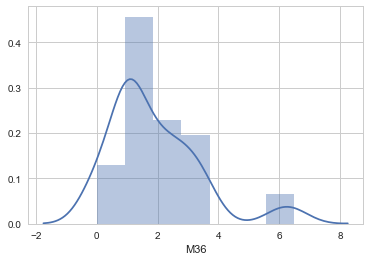

In [7]:
# model distribution of EDSS @ 36 months
distribution = sns.distplot(radiomic_raw['M36'])
np.mean(radiomic_raw['M36']) # mean of distribution

In [8]:
radiomic_raw.drop(
    [
        col for col in radiomic_raw.columns if # drop columns with unnesccsary info 
        'Unnamed: 0' in col or
        'scan_id' in col or
        'Image' in col or
        'Mask' in col or
        'M36_F' in col or # don't need two instances
        'general_info' in col 
    ], axis=1,inplace=True
)

In [9]:
radiomic_raw.drop(
    [
        col for col in radiomic_raw.columns if # drop columns with unnesccsary info 
        'shape' in col and '_F' in col # don't need two instances of shape features since independent of image type
    ], axis=1,inplace=True
)

In [10]:
radiomic_raw.head()

,Gender,M0,age_b,M36,original_shape_Maximum3DDiameter_T1,original_shape_Compactness2_T1,original_shape_Maximum2DDiameterSlice_T1,original_shape_Sphericity_T1,original_shape_MinorAxis_T1,original_shape_Compactness1_T1,...,wavelet-LLL_glszm_LargeAreaEmphasis_F,wavelet-LLL_glszm_ZoneVariance_F,wavelet-LLL_glszm_ZonePercentage_F,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis_F,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis_F,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_SmallAreaEmphasis_F,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_ZoneEntropy_F,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis_F
1,F,1.5,51,2.5,103.140681,0.012073,99.403219,0.229406,89.509623,0.005829,...,8.681753,4.791078,0.506976,0.005051,22332.881179,2058.785053,0.675129,0.001099,7.339516,0.000883
2,F,2.0,45,1.0,114.917362,0.029099,92.135769,0.307580,57.665033,0.009050,...,3.612393,1.378310,0.669037,0.001180,18802.976147,4252.182007,0.776257,0.000583,7.103329,0.000522
3,M,2.0,45,2.5,130.824310,0.008161,122.380554,0.201333,102.055353,0.004793,...,9.433625,5.724273,0.519219,0.002992,37926.000452,3411.233230,0.694034,0.000490,7.621857,0.000380
5,F,1.5,50,3.0,102.063706,0.101945,102.044108,0.467149,51.586776,0.016939,...,3.712381,1.396187,0.657071,0.005514,5627.337143,1501.295238,0.763852,0.003396,6.398713,0.003184
6,F,1.0,27,2.0,102.303470,0.036701,76.850504,0.332321,77.376122,0.010163,...,4.578785,1.606623,0.580048,0.005807,11530.889804,2337.272915,0.689258,0.002125,6.857161,0.001745


EDSS scores were partitioned into two groups, EDSS < 2 and EDSS ≥ 2, where the former was considered the negative class and the latter was considered the positive class. This stratification was performed in order to maintain an (approximately) equal class balance for use in machine learning analysis.

In [11]:
radiomic_raw.loc[radiomic_raw.M36 < 2, 'M36'] = 0 # Negative class
radiomic_raw.loc[radiomic_raw.M36 >= 2, 'M36'] = 1 # Positive class
radiomic_raw.M36 = radiomic_raw.M36.astype(int) # Change to integer 

# Binarize sex variable
radiomic_raw.loc[radiomic_raw.Gender == 'F', 'Gender'] = 0 
radiomic_raw.loc[radiomic_raw.Gender == 'M', 'Gender'] = 1
radiomic_raw.Gender = radiomic_raw.Gender.astype(int)

In [12]:
radiomic_raw.head()

,Gender,M0,age_b,M36,original_shape_Maximum3DDiameter_T1,original_shape_Compactness2_T1,original_shape_Maximum2DDiameterSlice_T1,original_shape_Sphericity_T1,original_shape_MinorAxis_T1,original_shape_Compactness1_T1,...,wavelet-LLL_glszm_LargeAreaEmphasis_F,wavelet-LLL_glszm_ZoneVariance_F,wavelet-LLL_glszm_ZonePercentage_F,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis_F,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis_F,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_SmallAreaEmphasis_F,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis_F,wavelet-LLL_glszm_ZoneEntropy_F,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis_F
1,0,1.5,51,1,103.140681,0.012073,99.403219,0.229406,89.509623,0.005829,...,8.681753,4.791078,0.506976,0.005051,22332.881179,2058.785053,0.675129,0.001099,7.339516,0.000883
2,0,2.0,45,0,114.917362,0.029099,92.135769,0.307580,57.665033,0.009050,...,3.612393,1.378310,0.669037,0.001180,18802.976147,4252.182007,0.776257,0.000583,7.103329,0.000522
3,1,2.0,45,1,130.824310,0.008161,122.380554,0.201333,102.055353,0.004793,...,9.433625,5.724273,0.519219,0.002992,37926.000452,3411.233230,0.694034,0.000490,7.621857,0.000380
5,0,1.5,50,1,102.063706,0.101945,102.044108,0.467149,51.586776,0.016939,...,3.712381,1.396187,0.657071,0.005514,5627.337143,1501.295238,0.763852,0.003396,6.398713,0.003184
6,0,1.0,27,1,102.303470,0.036701,76.850504,0.332321,77.376122,0.010163,...,4.578785,1.606623,0.580048,0.005807,11530.889804,2337.272915,0.689258,0.002125,6.857161,0.001745


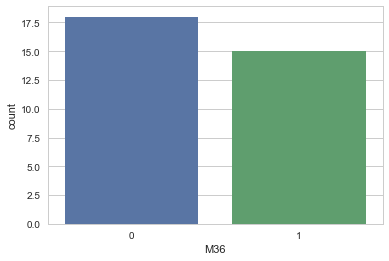

In [13]:
# Visualize counts of classes
gradebox = sns.countplot(x="M36", data = radiomic_raw)

## Assign Feature and Target Variables
These serve as inputs (X's) and outputs (y) for machine learning models.

In [14]:
# Make seperate dataframes with different features 

X_clinical = radiomic_raw.drop([col for col in radiomic_raw.columns if 
                      'age_b' not in col and 
                       'M0' not in col and 
                       'Gender' not in col 
                      ], axis = 1)

X_volume = radiomic_raw.drop([col for col in radiomic_raw.columns if 
                        'original_shape_Volume_T1' not in col 
                      ], axis = 1)

X_radiomic = radiomic_raw.drop(['M36','M0', 'Gender', 'age_b', 'original_shape_Volume_T1'], axis=1)

X_radiomic_volume = radiomic_raw.drop(['M36','M0', 'Gender', 'age_b'], axis=1)

X_radiomic_volume_clinical = radiomic_raw.drop(['M36'], axis=1) 

y = radiomic_raw['M36'] # target variable

## Exploratory Machine Learning 

Supervised machine learning classification encompasses the approximation of an underlying function from labeled training data to predict the class of a new unseen sample. In our case the input data are the radiomic features for an MRI of a given patient and the output class is the EDSS at 36 months for that patient (stratified via cutoff score of 2; EDSS < 2 = 0, EDSS ≥ 2 = 1). To investigate the feasibility of radiomic analysis on our dataset we generated several combinations of machine learning models constructed from different machine learning classifier methods and a variable number of top features chosen via a univariate feature selection method (ANOVA F-score).

Ideally, machine learning should be performed on an independent training and testing/validation set. However, due to the small size of our dataset (n = 33), we utilized cross validation to evaluate each machine learning model, thereby maximizing training samples used for the analysis. The cross validation procedure is described as follows. The dataset was randomly shuffled then split into 30 consecutive folds, each fold was then used once as the testing set while the 29 remaining folds formed the training set to calculate the mean model percent correct accuracy (30-fold cross validation). This entire process was then repeated 100 times with random shuffling and the corresponding classifier in a new random state for each iteration. The final reported accuracy value was the mean accuracy after all 100 iterations of cross validation. This repeat iteration process was performed to minimize the probability that a high-performing model was constructed by random chance alone. The best performing model was then selected for further analysis. 

*This takes approximatley 3 hours to run on a normal CPU.* 

In [15]:
%%time

master_df = pd.DataFrame(columns = [
    'CLF', 'FN', 'ACC_mean', 'ACC_SD', 'RSD',
]) # create dataframe where all values will be stored for each combination

clf_A = DecisionTreeClassifier(random_state=0)  # Ensure all classifiers are set to random states if applicable 
clf_B = RandomForestClassifier(random_state=0)
clf_C = BaggingClassifier(random_state=0)
clf_D = GradientBoostingClassifier(random_state=0)
clf_E = GaussianNB()
clf_F = MLPClassifier(random_state=0)
clf_G = SVC(random_state=0, probability=True, kernel='linear') # Need probability to be true so can use AUC score 
clf_H = LogisticRegression(random_state=0)
clf_I = KNeighborsClassifier()

clf_list = [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I]

feature_number_list = [1,10,100,250,500,1000,1418] # number of top features to try

for clf in clf_list:
    for feature_number in feature_number_list:
            
        accuracy_list = [] # Empty list to be filled 
            
        # Iterate 100 times 
        for i in range(100):
            cv = KFold(random_state=i, shuffle=True, n_splits=30) # 30-fold cross validation, didn't use Leave one out to allow for randomness in repeated iterations
            
            classifier = make_pipeline(StandardScaler(), SelectKBest(k=feature_number), clf) # Normalize features, select top features
            
            scores = cross_val_score(classifier, X_radiomic_volume, y, cv=cv, scoring='accuracy') # Calculate cross validation 
            
            accuracy_list.append(scores.mean()) # Add the mean score of 1 cross validation iteration 
                
        master_df = master_df.append(
            {
            'CLF': str(clf.__class__.__name__), # classifier name
            'FN': feature_number, # number of features 
            'ACC_mean': np.mean(accuracy_list), # mean of 100 iterations of cross validation 
            'ACC_SD': np.std(accuracy_list),
            'RSD': np.std(accuracy_list)/np.mean(accuracy_list)*100, # Relative standard deviation (RSD) as defined by Parmer et al 2015
            }, ignore_index = True)
        #print master_df # uncomment for debugging

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


CPU times: user 2h 33min 23s, sys: 2min 49s, total: 2h 36min 13s
Wall time: 2h 43min 14s


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Text yticklabel objects>)

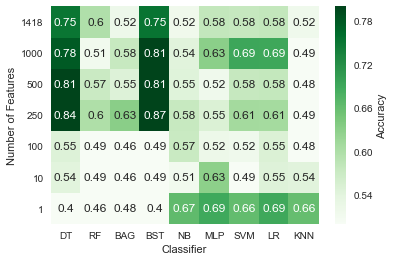

In [16]:
# Heatmap of classifier performance

labels = ['DT', 'RF', 'BAG', 'BST', 'NB', 'MLP', 'SVM', 'LR', 'KNN']

master_heatmap_df = pd.DataFrame(index = feature_number_list, columns = [clf.__class__.__name__ for clf in clf_list])

for feature_number in feature_number_list:
    for clf in clf_list: 
        master_heatmap_df.set_value(feature_number, clf.__class__.__name__, master_df[(master_df['FN'] == feature_number) &
                                                                                        (master_df['CLF'] == clf.__class__.__name__)].iloc[0]['ACC_mean'])
        master_heatmap_df = master_heatmap_df[master_heatmap_df.columns].astype(float)

heatmap = sns.heatmap(master_heatmap_df, cmap = 'Greens', cbar_kws={'label': 'Accuracy', 'format': '%.2f'}, vmin = 0.5, vmax = 0.8, xticklabels=labels, annot= True)
heatmap.set(xlabel='Classifier', ylabel='Number of Features') 
heatmap.invert_yaxis()
plt.yticks(rotation=0)

#plt.savefig('Exploratory_machine_learning_analysis.pdf', bbox_inches='tight') # uncomment to save figure

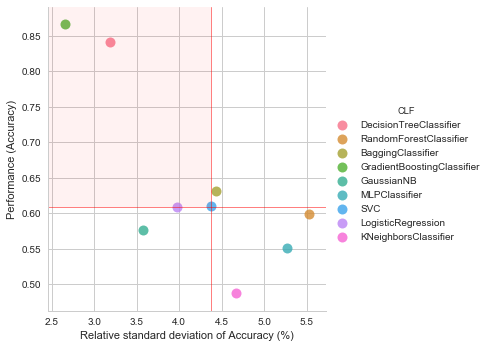

In [17]:
# Scatterplot of RSD vs. accuracy 

# Get median values 
AUC_median = master_df[((master_df.FN == 250))]["ACC_mean"].median()
RSD_median = master_df[((master_df.FN == 250))]['RSD'].median()

# Create scatterplot
lm = sns.lmplot(
    x="RSD", y="ACC_mean", hue = 'CLF', data = master_df[((master_df.FN == 250))], 
    fit_reg=False, scatter_kws={"s": 100}
)

# Set labels
lm.set_ylabels('Performance (Accuracy)')
lm.set_xlabels('Relative standard deviation of Accuracy (%)')

# Get axis extrema to draw lines and boxes
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()

# Plot median lines for AUC and RSD + highlighted area for classifiers with AUC > median and RSD < median
plt.axhline(y= AUC_median, linewidth=1, color = 'red', alpha=0.5)
plt.axvline(x= RSD_median, linewidth=1, color = 'red', alpha=0.5)
lm.axes[0][0].add_patch(patches.Rectangle((x_min, AUC_median), width= (RSD_median-x_min), height=(y_max-AUC_median), facecolor="red", alpha = 0.05))
#plt.savefig("scatter.pdf", bbox_inches='tight') # uncomment to save figure

## Comparison of Radiomic, Clinical and Volumetric Models

The best radiomics machine learning model, Gradient Boosting with the top 250 features, was selected to be compared with Gradient Boosting models constructed from clinical and volumetric data alone. 
*This takes about 20 minutes to run on a normal CPU.*

In [18]:
%%time

X_clinical_list = [] # need to populate lists to utilize with t-test comparisons below
X_volume_list = []
X_radiomic_list = []
X_radiomic_volume_list = []
X_radiomic_volume_clinical_list = []

X_list = [[X_clinical, 'clinical'], 
          [X_volume, 'volume'],
          [X_radiomic, 'radiomic'], 
          [X_radiomic_volume, 'radiomic+volume'],
          [X_radiomic_volume_clinical, 'radiomic+volume+clinical']
         ] # make lists 

df_compare = pd.DataFrame(columns = [
    'method', 'accuracy', 
]) # this is a dataframe where every iteration will have its own row, i.e. for X = clinical there will be 100 entries,
   # this way we can plot error bars on barchart below

for X in X_list:
    scores_list = []
    for i in range(100): # iterate 100 times
        cv = KFold(random_state=i, shuffle=True, n_splits=30) # 30-fold cross validation to eliminate randomness
        if X[1] == 'clinical' or X[1] == 'volume':
            clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=i)) # for the case where there's only 1 feature
        else:
            clf = make_pipeline(StandardScaler(), SelectKBest(k=250), GradientBoostingClassifier(random_state=i)) # otherwise use top features
        scores = cross_val_score(clf, X[0], y, cv=cv, scoring='accuracy')
        # print X[1] + ' ' + str(scores.mean()) # uncomment for debugging 
        scores_list.append(scores.mean())
        if X[1] == 'clinical':
            X_clinical_list.append(scores.mean())
        elif X[1] == 'volume':
            X_volume_list.append(scores.mean())
        elif X[1] == 'radiomic':
            X_radiomic_list.append(scores.mean())
        elif X[1] == 'radiomic+volume':
            X_radiomic_volume_list.append(scores.mean())
        elif X[1] == 'radiomic+volume+clinical':
            X_radiomic_volume_clinical_list.append(scores.mean())
        df_compare = df_compare.append(
        {
        'method': X[1], 
        'accuracy': scores.mean()
        }, ignore_index = True)

CPU times: user 17min 58s, sys: 11.2 s, total: 18min 9s
Wall time: 18min 47s


In [19]:
df_compare # show dataframe

,method,accuracy
0,clinical,0.566667
1,clinical,0.550000
2,clinical,0.600000
3,clinical,0.583333
4,clinical,0.583333
5,clinical,0.533333
6,clinical,0.550000
7,clinical,0.550000
8,clinical,0.550000
9,clinical,0.550000


To directly compare the radiomic, clinical, and volumetric models, we utilized a two-tailed Welch's t-test between each model accuracy and reported p values < 0.001 being significantly different. 

In [21]:
# Perform significance testing 
t_test_volume_radiomic = ttest_ind(X_volume_list,X_radiomic_list, equal_var=False) # equal var set to false = Welch's t-test
t_test_clinical_volume = ttest_ind(X_clinical_list,X_volume_list, equal_var=False)
t_test_clinical_radiomic = ttest_ind(X_clinical_list,X_radiomic_list, equal_var=False)

print "volume vs. radiomic " + str(t_test_volume_radiomic)
print "clinical vs. volume " + str(t_test_clinical_volume)
print "clinical vs. radiomic " + str(t_test_clinical_radiomic)

volume vs. radiomic Ttest_indResult(statistic=-78.563323922584644, pvalue=5.1653053887741324e-146)
clinical vs. volume Ttest_indResult(statistic=-29.454032647331552, pvalue=9.5974512760813903e-73)
clinical vs. radiomic Ttest_indResult(statistic=-98.262609821038538, pvalue=6.4385197410915398e-170)


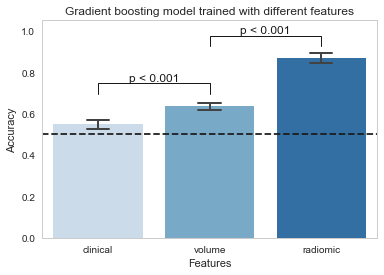

In [24]:
# make barplot

sns.barplot(data=df_compare[(df_compare['method'] == 'clinical') | (df_compare['method'] == 'volume') | (df_compare['method'] == 'radiomic')],
            x='method', y='accuracy', ci='sd', errwidth =2, capsize=0.2, palette = 'Blues') # just make barplot comparing clinical vs. volume. vs. radiomic 

# statistical annotation, make lines that represent significance differences 
x1, x2 = 0, 1   
y1, h, col = df_compare['accuracy'].max() - 0.22, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1, c=col)
plt.text((x1+x2)*.5, y1+h, "p < 0.001", ha='center', va='bottom', color=col)
x3, x4 = 1, 2   
y2, h2, col2 = df_compare['accuracy'].max() + 0.01, 0.05, 'k'
plt.plot([x3, x3, x4, x4], [y2, y2+h2, y2+h2, y2], lw=1, c=col)
plt.text((x3+x4)*.5, y2+h2, "p < 0.001", ha='center', va='bottom', color=col)

plt.axhline(y=0.5, color='k', linestyle='--') # make a horizontal line to represent random guessing

plt.ylim(0,1.05) # raise y axis limit to make graph look nice
plt.grid(False) # remove grid to make graph look nice

plt.title('Gradient boosting model trained with different features')
plt.xlabel('Features')
plt.ylabel('Accuracy')

#plt.savefig('barplot.pdf', bbox_inches='tight') # uncomment to save figure

## Effect of Training Size on Performance
Essentially plotting a "learning curve" to see how much the cross validation fold size makes a difference in model performance (accuracy). https://stats.stackexchange.com/questions/51490/how-large-a-training-set-is-needed . * This takes about 1 hour to run on a normal CPU.*

In [25]:
%%time

linecomp_df = pd.DataFrame(columns = [
    'SPLITS', 
    'ACC_mean', 'ACC_median', 'ACC_std'
]) # create dataframe where all values will be stored for each combo

n_split_sizes = range(2,31,1) # build with these training sizes 

for size in n_split_sizes:
    accuracy_list = []
    for i in range(100):
        cv1 = KFold(random_state=i, shuffle=True, n_splits=size) 
        clf = make_pipeline(StandardScaler(), SelectKBest(k=250), GradientBoostingClassifier(random_state=i)) 
        scores = cross_val_score(clf, X_radiomic, y, cv=cv1, scoring='accuracy')
        accuracy_list.append(scores.mean())
    
    linecomp_df = linecomp_df.append(
        {
            'SPLITS': size, 
            'ACC_mean': np.mean(accuracy_list),
            'ACC_median': np.median(accuracy_list),
            'ACC_std': np.std(accuracy_list)
        }, ignore_index = True)

    #print linecomp_df # debugging 

CPU times: user 1h 10min 58s, sys: 49.1 s, total: 1h 11min 47s
Wall time: 1h 15min 19s


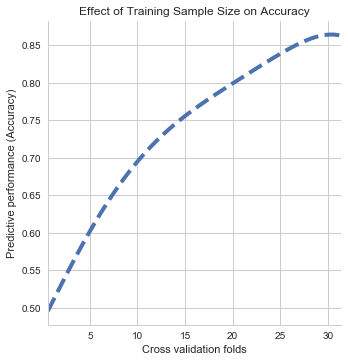

In [26]:
ax = sns.lmplot(x="SPLITS", y="ACC_mean", data=linecomp_df,
           fit_reg=True, order=5, ci=None, line_kws={'linestyle': '--', 'linewidth': 4},
                legend_out = False, scatter_kws={'s':100}, markers='')

ax.set_ylabels('Predictive performance (Accuracy)')
ax.set_xlabels('Cross validation folds') 
ax.set(title='Effect of Training Sample Size on Accuracy')

#ax.savefig("splitsize.pdf", bbox_inches='tight') # uncomment to save figure